In [1]:
import numpy as np
import sympy as sy
from matplotlib import pyplot as plt
from IPython.display import display
import pickle
from itertools import product

In [2]:
save_res = False
num_samples = 1 #per q value
all_data = {'q': np.linspace(0,1,9), 
            'phase_fraction': {'wav': [], 
                               'st': [], 
                               'stab': []}}
kappa, lamda = sy.symbols("kappa lamda")
for q in all_data['q']:
    data = {'kappa_cs': {'wav': [], 'st': []},
            'omega_integrand': {'wav': [], 'st': [], 'stab': []}}
    while len(data['kappa_cs']['wav']) < num_samples:
        # Construct metacommunity jacobian
        'This J construction seems to always be stable'
        J_sub = np.random.normal(0, 0.2, (3,3))
        for i in range(3):
            J_sub[i,i] = -1.
        evs = np.linalg.eig(J_sub)[0]
        if not np.all(np.real(evs) < 0):
            continue
        C = np.zeros((3,3))
        for i, j in product(range(C.shape[0]), repeat=2):
            if i == j:
                C[i,j] = 1.0
            elif np.random.binomial(1, q):
                C[i,j] = np.random.uniform() * -np.sign(J_sub[i,j])
        M_sub = J_sub - kappa*C

        # Get oscillatory and stationary pattern-forming instability conditions
        M_star = sy.zeros(3,3)
        for i,j in product(range(C.shape[0]), repeat=2):
            if C[i,j] != 0:
                M_star[i,j] = -C[i,j]*kappa
            else:
                M_star[i,j] = J_sub[i,j]
        p = M_star.charpoly(lamda) #characteristic polynomial
        p_coeffs = p.all_coeffs()
        I_wav_sub = p_coeffs[3] - p_coeffs[1]*p_coeffs[2] #oscillatory
        I_st_sub = p_coeffs[3] #stationary

        # Find and store critical kappas
        kappa_wavs, kappa_sts = ([], [])
        try:
            wav_sols = sy.solveset(I_wav_sub, kappa).args
            st_sols = sy.solveset(I_st_sub, kappa).args
        except:
            wav_sols, st_sols = ([np.nan, np.nan, np.nan], [np.nan, np.nan, np.nan])
        for sol in wav_sols:
            try:
                kappa_wavs.append(float(sol))
            except:
                kappa_wavs.append(complex(sol))
        for sol in st_sols:
            try:
                kappa_sts.append(float(sol))
            except:
                kappa_sts.append(complex(sol))
        for cond, kappa_arr in zip(['wav', 'st'], [kappa_wavs, kappa_sts]):
            kappa_c_dir = []
            for kappa_c in kappa_arr:
                if np.isreal(kappa_c) and (kappa_c > 0):
                    kappa_c_dir.append(kappa_c)
                else:
                    kappa_c_dir.append(np.nan)
            data['kappa_cs'][cond].append(kappa_c_dir)

        # Store linear stability type (Omega integrand)
        wav_nonan = [val for val in data['kappa_cs']['wav'][-1] if not np.isnan(val)]
        st_nonan = [val for val in data['kappa_cs']['st'][-1] if not np.isnan(val)]
        wav = len(wav_nonan) > 0
        st = len(st_nonan) > 0
        if wav and st:
            wav_before_st = min(wav_nonan) < min(st_nonan)
            st_before_wav = min(st_nonan) < min(wav_nonan)
        else:
            wav_before_st = wav
            st_before_wav = st
        data['omega_integrand']['wav'].append(wav_before_st)
        data['omega_integrand']['st'].append(st_before_wav)
        data['omega_integrand']['stab'].append((wav == False) and (st == False))
        
    for phase in ['wav', 'st', 'stab']:
        phase_fraction = sum(data['omega_integrand'][phase]) / num_samples
        all_data['phase_fraction'][phase].append(phase_fraction)
    
# Save data to pkl
if save_res:
    with open('random_matrix_test.pkl', 'wb') as f:
        pickle.dump(all_data, f)

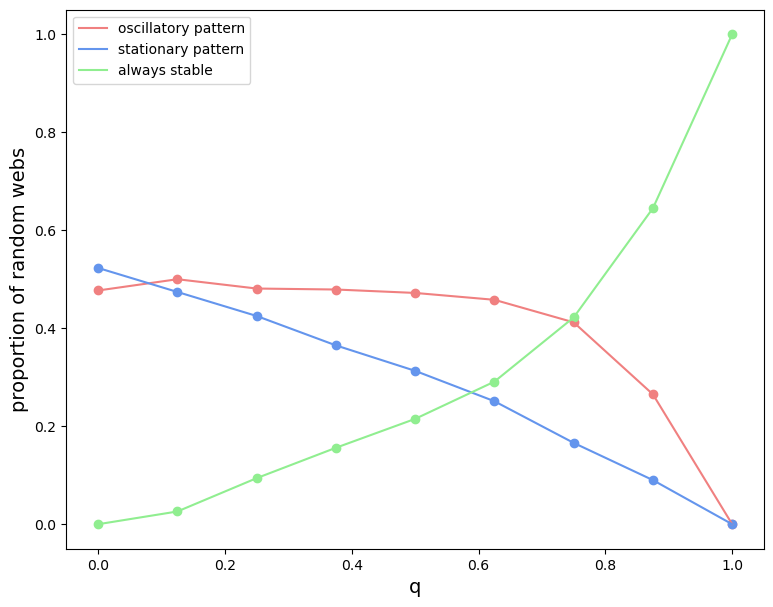

In [3]:
savefig = True
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'random_matrix_test.png'
with open('random_matrix_test.pkl', 'rb') as file:
    all_data = pickle.load(file)
plt.figure(figsize=(9,7))
ax = plt.subplot()
phases = ['wav', 'st', 'stab']
colors = ['lightcoral', 'cornflowerblue', 'lightgreen']
labels = ['oscillatory pattern', 'stationary pattern', 'always stable']
for i, phase in enumerate(phases):
    ax.scatter(all_data['q'], all_data['phase_fraction'][phase], 
               c=colors[i])
    ax.plot(all_data['q'], all_data['phase_fraction'][phase], 
               c=colors[i], label=labels[i])
ax.set_xlabel('q', fontsize=14)
ax.set_ylabel('proportion of random webs', fontsize=14)
ax.legend()
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')